In [1]:
from PIL import Image
import os

path = "\\myData"

i=0
for r, d, f in os.walk(path):
    for file in f:
        if file.endswith('.png'):
            pat=os.path.join(r, file)
            with Image.open(pat) as im:
                if im.size!=(32, 32):
                    im=im.resize((32, 32),Image.LANCZOS)
                im.save(pat.replace(".png",".jpg"))
            os.remove(pat)
            i+=1
            print(i,end='\r')
        elif file.endswith('.jpg'):
            pat=os.path.join(r, file)
            with Image.open(pat) as im:
                if im.size!=(32, 32):
                    im=im.resize((32, 32),Image.LANCZOS)
                    im.save(pat)
                    i+=1
                    print(i,end='\r')



In [1]:
import os
import numpy as np
from PIL import Image
from multiprocessing import Pool, cpu_count

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = r"myData"


In [3]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


class TrafficSignDataset(Dataset):
    def __init__(self, root_dir):
        self.paths = []
        self.labels = []

        for label in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for f in os.listdir(class_dir):
                        self.paths.append(os.path.join(class_dir, f))
                        self.labels.append(int(label))

        
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return img, label



dataset = TrafficSignDataset(data_path)

loader = DataLoader(
    dataset,
    batch_size=256,   
    shuffle=False,
    num_workers=0,    
    pin_memory=False
)


all_images = []
all_labels = []

for imgs, labels in loader:
    imgs_np = imgs.permute(0, 2, 3, 1).numpy()
    all_images.append(imgs_np)
    all_labels.append(labels.numpy())

images = np.concatenate(all_images)
labels = np.concatenate(all_labels)

print("Loaded images:", images.shape)
print("Loaded labels:", labels.shape)
X = images.reshape(len(images), -1) 
y = labels

print("X:", X.shape)
print("y:", y.shape)


In [4]:
np.savez("traffic_signs_32x32.npz", images=images, labels=labels)
print("Saved ")

Saved!


In [3]:
# pour eviter de load toutes les images a chaque fois
data = np.load("traffic_signs_32x32.npz")
images = data["images"]
labels = data["labels"]

In [12]:
images = np.array(images)
labels = np.array(labels)

X = images.reshape(images.shape[0], -1)
y = labels

print("X shape:", X.shape)

X shape: (73139, 3072)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (58511, 3072)
Test: (14628, 3072)


In [7]:
clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=25,
    min_samples_split=10,
    random_state=42
)

clf.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,25
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [10]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8340169537872573

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        90
           1       0.80      0.81      0.80       984
           2       0.65      0.68      0.66       522
           3       0.73      0.78      0.75       534
           4       0.80      0.83      0.82       750
           5       0.68      0.70      0.69       702
           6       0.82      0.79      0.81       156
           7       0.75      0.73      0.74       546
           8       0.74      0.79      0.76       534
           9       0.89      0.89      0.89       558
          10       0.91      0.91      0.91       762
          11       0.90      0.88      0.89       498
          12       0.87      0.87      0.87       798
          13       0.93      0.93      0.93       816
          14       0.90      0.91      0.91       294
          15       0.83      0.77      0.80       234
          16       0.89     

In [8]:

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8340169537872573

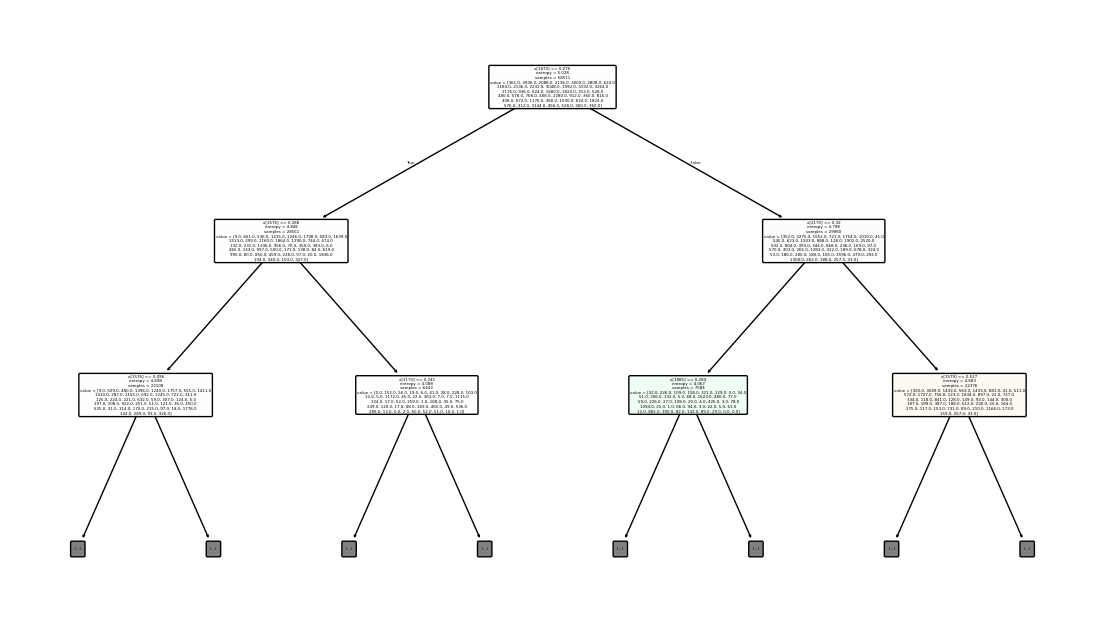

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(14, 8))
plot_tree(
    clf,
    max_depth=2,            
    filled=True,
    rounded=True
)
plt.show()


In [14]:

accuracies = []

plt.ion()
fig, ax = plt.subplots(figsize=(8, 5))

depth = 5
while depth != 100:
    clf_temp = DecisionTreeClassifier(
        criterion="entropy",
        max_depth=depth,
        min_samples_split=10,
        random_state=42
    )
    clf_temp.fit(X_train, y_train)
    y_pred_temp = clf_temp.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)


    ax.clear()
    ax.plot(depth_values[:len(accuracies)], accuracies, marker='o')
    ax.set_title("Decision Tree Accuracy (Live)")
    ax.set_xlabel("Max Depth")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    plt.pause(0.2)
    depth += 5

plt.ioff()
plt.show()